In [3]:
import numpy as np
from scipy.linalg import eigh, pinv 

from numpy.linalg import norm
import warnings
warnings.filterwarnings("ignore")
def normalize(X):
    return (X - np.mean(X, axis=0)) / (np.std(X, axis=0) + 1e-10)
def Lap(S):
    D = np.diag(np.sum(S, axis=1))
    return D - S
def get_Bipartite(X, h, mode=1):
    n = X.shape[1]
    idx = np.random.choice(n, h, replace=False)
    return X[:, idx]


In [4]:


def BGLR(X, k, m, h, beta, eta, maxIter):
    d, n = X.shape
    W = np.random.rand(d, m)
    P = np.zeros((n, h))
    lossFun = np.zeros(maxIter)
    E1 = np.zeros((n, n))
    E2 = np.zeros((h, h))
    I = np.eye(d)
    I1 = np.ones((d, d))
    di = np.zeros(n)

    featuresX = normalize(X.T)
    S1 = featuresX @ featuresX.T
    np.fill_diagonal(S1, 0)

    Z = get_Bipartite(X, h)

    for i in range(maxIter):
        print(f"Iteration {i + 1} ---")
        print("Updating P...")
        di = np.zeros(n)
        for r in range(n):
            for l in range(m):
                di[r] += np.exp(-norm(W.T @ X[:, r] - W.T @ Z[:, l])**2 / eta)
            for j in range(h):
                P[r, j] = np.exp(-norm(W.T @ X[:, r] - W.T @ Z[:, j])**2 / eta) / (di[r] + np.finfo(float).eps)

        print("Updating W...")
        new_X = np.concatenate((X, Z), axis=1)
        S = np.block([[E1, P], [P.T, E2]])
        L_S = Lap(S)
        A_X = new_X @ L_S @ new_X.T + beta * I1
        A_X[np.isnan(A_X) | np.isinf(A_X)] = 1

        # Correction pour la décomposition propre
        eigenvalues, _ = eigh(A_X)
        lambda_max = np.max(np.real(eigenvalues))
        G = lambda_max * I - A_X

        if np.linalg.matrix_rank(G) <= m:
            Q1 = np.zeros((d, k))
            idx1 = np.argsort(np.diag(G))[::-1][:k]
            for s, b in enumerate(idx1):
                Q1[b, s] = 1
            M1 = Q1.T @ G @ Q1
            # Correction pour eigh
            eigenvalues, U1 = eigh(M1)
            U1 = U1[:, -m:]  # Prendre les m derniers vecteurs propres
            W = Q1 @ U1
        else:
            loss = np.zeros(20)
            for time in range(20):
                E = G - G @ W @ pinv(W.T @ G @ W) @ W.T @ G
                Q2 = np.zeros((d, k))
                idx2 = np.argsort(np.diag(E))[::-1][:k]
                for s, b in enumerate(idx2):
                    Q2[b, s] = 1
                M2 = Q2.T @ E @ Q2
                # Correction pour eigh
                eigenvalues, U2 = eigh(M2)
                U2 = U2[:, -m:]  # Prendre les m derniers vecteurs propres
                W = np.real(Q2 @ U2)
                loss[time] = np.trace(W.T @ E @ W)

        print("Calculating loss...")
        tem1 = np.trace(W.T @ new_X @ L_S @ new_X.T @ W)
        tem2 = beta * np.trace(W.T @ I1 @ W)
        tem3 = -eta * np.sum(P * np.log(P + 1e-10))
        lossFun[i] = tem1 + tem2 + tem3

        if i > 10 and abs((lossFun[i] - lossFun[i-1]) / lossFun[i]) < 1e-5:
            break

    index = np.where(W != 0)[0]
    newfea = X[index[:k], :]
    return W, index, newfea, lossFun

In [ ]:
# Assurez-vous d'avoir 'from scipy.io import loadmat' en haut de votre script
from scipy.io import loadmat
# Chargez les données depuis le fichier .mat
mat_data = loadmat("C:\\Users\\PC\\Desktop\\PFE-MNSA\\DATA\\USPS.mat")

# Extrayez la matrice de données. Assurez-vous que 'X' est la bonne clé pour vos données.
# Si vos données sont (samples x features) et que la fonction attend (features x samples), utilisez .T
X = mat_data['X'].T

# Exemple d'appel avec vos données chargées
W, index, newfea, lossFun = BGLR(X, k=10, m=5, h=15, beta=0.1, eta=0.5, maxIter=30)

Iteration 1 ---
Updating P...
Updating W...
Calculating loss...
Iteration 2 ---
Updating P...
Updating W...
Calculating loss...
Iteration 3 ---
Updating P...
Updating W...
Calculating loss...
Iteration 4 ---
Updating P...
Updating W...
Calculating loss...
Iteration 5 ---
Updating P...
Updating W...
Calculating loss...
Iteration 6 ---
Updating P...
Updating W...
Calculating loss...
Iteration 7 ---
Updating P...
Updating W...
Calculating loss...
Iteration 8 ---
Updating P...
Updating W...
Calculating loss...
Iteration 9 ---
Updating P...
Updating W...
Calculating loss...
Iteration 10 ---
Updating P...
Updating W...
Calculating loss...
Iteration 11 ---
Updating P...
Updating W...
Calculating loss...
Iteration 12 ---
Updating P...
Updating W...
Calculating loss...


In [6]:
print("Matrice de projection W:\n", W)
print("Matrice de projection W:\n", W.shape)


Matrice de projection W:
 [[ 2.97789315e-03 -6.78131779e-04  8.48492660e-01 -2.44535358e-01
  -4.17825200e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 ...
 [-3.14664973e-01  1.89605109e-01 -1.04546174e-02 -3.27174716e-02
   6.51661769e-02]
 [ 5.17200015e-01 -6.32526587e-01  4.25432020e-02  1.58098117e-01
  -2.87216401e-01]
 [ 4.15073727e-01  9.81742267e-02  1.65748000e-03 -1.62222253e-02
   8.70237342e-01]]
Matrice de projection W:
 (256, 5)


In [7]:
from scipy.optimize import linear_sum_assignment
def clustering_accuracy(y_true, y_pred):
    D = max(y_pred.max(), y_true.max()) + 1
    confusion = np.zeros((D, D), dtype=np.int64)
    for i in range(len(y_true)):
        confusion[y_pred[i], y_true[i]] += 1
    row_ind, col_ind = linear_sum_assignment(-confusion)
    return confusion[row_ind, col_ind].sum() / len(y_true)


In [8]:
selected_indices = np.where(np.linalg.norm(W, axis=1) > 1e-6)[0]


In [9]:
X_selected = X[selected_indices, :]  # X : matrice originale (d x n)


In [11]:
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler

# Charger les données
data = load_digits()
X = data.data.T         # (d x n)
y_true = data.target    # (n,)

# Normalisation (optionnelle mais recommandée)
X = StandardScaler().fit_transform(X.T).T


In [12]:
from sklearn.cluster import KMeans
X_selected_T = X_selected.T  # n x k
n_clusters = len(np.unique(y_true))

kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=0)
y_pred = kmeans.fit_predict(X_selected_T)


In [13]:
acc = clustering_accuracy(y_true, y_pred)
print(f"Accuracy (ACC) = {acc:.4f}")


Accuracy (ACC) = 0.1180


In [14]:
from scipy.io import loadmat
import numpy as np

# Charger les données
mat_data = loadmat("C:\\Users\\PC\\Desktop\\PFE-MNSA\\DATA\\USPS.mat")

# Adapter selon structure réelle du .mat :
X = mat_data['X'].T  # (features x samples)

# Assurez-vous qu'il existe aussi un vecteur d'étiquettes
y_true = mat_data['Y'].flatten()  #

In [15]:
print(mat_data.keys())


dict_keys(['__header__', '__version__', '__globals__', 'X', 'Y'])


In [18]:
# Normaliser les données
X = (X - np.mean(X, axis=0)) / (np.std(X, axis=0) + 1e-10)

# Paramètres BGLR
k = 200       # nombre de caractéristiques à sélectionner
m = 190        # dimension projetée
h = 1500       # nombre d'ancres
beta = 0.1
eta = 1.0
maxIter = 20

# Appel de BGLR
W, index, newfea, lossFun = BGLR(X, k, m, h, beta, eta, maxIter)


Iteration 1 ---
Updating P...
Updating W...
Calculating loss...
Iteration 2 ---
Updating P...
Updating W...
Calculating loss...
Iteration 3 ---
Updating P...
Updating W...
Calculating loss...
Iteration 4 ---
Updating P...
Updating W...
Calculating loss...
Iteration 5 ---
Updating P...
Updating W...
Calculating loss...
Iteration 6 ---
Updating P...
Updating W...
Calculating loss...
Iteration 7 ---
Updating P...
Updating W...
Calculating loss...
Iteration 8 ---
Updating P...
Updating W...
Calculating loss...
Iteration 9 ---
Updating P...
Updating W...
Calculating loss...
Iteration 10 ---
Updating P...
Updating W...
Calculating loss...
Iteration 11 ---
Updating P...
Updating W...
Calculating loss...
Iteration 12 ---
Updating P...
Updating W...
Calculating loss...
Iteration 13 ---
Updating P...
Updating W...
Calculating loss...
Iteration 14 ---
Updating P...
Updating W...
Calculating loss...
Iteration 15 ---
Updating P...
Updating W...
Calculating loss...
Iteration 16 ---
Updating P...
Upd

In [20]:
from sklearn.cluster import KMeans
from scipy.optimize import linear_sum_assignment

def clustering_accuracy(y_true, y_pred):
    D = max(y_pred.max(), y_true.max()) + 1
    confusion = np.zeros((D, D), dtype=np.int64)
    for i in range(len(y_true)):
        confusion[y_pred[i], y_true[i]] += 1
    row_ind, col_ind = linear_sum_assignment(-confusion)
    return confusion[row_ind, col_ind].sum() / len(y_true)

# Transposer les features sélectionnées pour clustering (samples x features)
X_selected = newfea.T

# Clustering
n_clusters = len(np.unique(y_true))
kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=0)
y_pred = kmeans.fit_predict(X_selected)

# Accuracy
acc = clustering_accuracy(y_true, y_pred)
print(f"Accuracy (ACC) = {acc:.4f}")


Accuracy (ACC) = 0.2893


DATA2 2

In [4]:
from scipy.io import loadmat
import numpy as np

# Charger les données
mat_data = loadmat("C:\\Users\\PC\\Desktop\\PFE-MNSA\\DATA\\PCMAC.mat")

# Adapter selon structure réelle du .mat :
X = mat_data['X'].T  # (features x samples)

# Assurez-vous qu'il existe aussi un vecteur d'étiquettes
y_true = mat_data['Y'].flatten()  #

In [5]:
# Normaliser les données
X = (X - np.mean(X, axis=0)) / (np.std(X, axis=0) + 1e-10)

# Paramètres BGLR
k = 200       # nombre de caractéristiques à sélectionner
m = 190        # dimension projetée
h = 500       # nombre d'ancres
beta = 0.1
eta = 1.0
maxIter = 20

# Appel de BGLR
W, index, newfea, lossFun = BGLR(X, k, m, h, beta, eta, maxIter)

Iteration 1 ---
Updating P...
Updating W...
Calculating loss...
Iteration 2 ---
Updating P...
Updating W...
Calculating loss...
Iteration 3 ---
Updating P...
Updating W...
Calculating loss...
Iteration 4 ---
Updating P...
Updating W...
Calculating loss...
Iteration 5 ---
Updating P...
Updating W...
Calculating loss...
Iteration 6 ---
Updating P...
Updating W...
Calculating loss...
Iteration 7 ---
Updating P...
Updating W...
Calculating loss...
Iteration 8 ---
Updating P...
Updating W...
Calculating loss...
Iteration 9 ---
Updating P...
Updating W...
Calculating loss...
Iteration 10 ---
Updating P...
Updating W...
Calculating loss...
Iteration 11 ---
Updating P...
Updating W...
Calculating loss...
Iteration 12 ---
Updating P...
Updating W...
Calculating loss...
Iteration 13 ---
Updating P...
Updating W...
Calculating loss...
Iteration 14 ---
Updating P...
Updating W...
Calculating loss...
Iteration 15 ---
Updating P...
Updating W...
Calculating loss...
Iteration 16 ---
Updating P...
Upd

In [7]:
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import normalized_mutual_info_score
from scipy.optimize import linear_sum_assignment

# Vos fonctions de métriques
def clustering_accuracy(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    row_ind, col_ind = linear_sum_assignment(-w)
    return sum([w[i, j] for i, j in zip(row_ind, col_ind)]) / y_pred.size



# Transposer les features sélectionnées pour clustering (samples x features)
X_selected = newfea.T

# Clustering
n_clusters = len(np.unique(y_true))
kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=0)
y_pred = kmeans.fit_predict(X_selected)

# Accuracy
acc = clustering_accuracy(y_true, y_pred)
print(f"Accuracy (ACC) = {acc:.4f}")


Accuracy (ACC) = 0.5054


In [5]:
from scipy.io import loadmat
import numpy as np
from sklearn.cluster import KMeans
from collections import Counter
from math import log, sqrt

# Fonction pour calculer l'entropie d'une distribution
def entropy(labels):
    n = len(labels)
    label_counts = Counter(labels)
    return -sum((count/n) * log(count/n + 1e-10) for count in label_counts.values())

# Fonction pour calculer l'information mutuelle
def mutual_info(y_true, y_pred):
    n = len(y_true)
    true_counts = Counter(y_true)
    pred_counts = Counter(y_pred)
    joint_counts = Counter(zip(y_true, y_pred))

    mi = 0.0
    for (yt, yp), count in joint_counts.items():
        p_joint = count / n
        p_yt = true_counts[yt] / n
        p_yp = pred_counts[yp] / n
        mi += p_joint * log(p_joint / (p_yt * p_yp) + 1e-10)
    return mi

# Fonction pour calculer la NMI à partir de la formule de l’image
def nmi_manual(y_true, y_pred):
    mi = mutual_info(y_true, y_pred)
    h_true = entropy(y_true)
    h_pred = entropy(y_pred)
    return mi / sqrt(h_true * h_pred + 1e-10)


# Charger les données
mat_data = loadmat("C:\\Users\\PC\\Desktop\\PFE-MNSA\\DATA\\PCMAC.mat")

# Adapter selon la structure du fichier .mat
X = mat_data['X'].T
y_true = mat_data['Y'].flatten()

# Normaliser les données
X = (X - np.mean(X, axis=0)) / (np.std(X, axis=0) + 1e-10)

# Paramètres BGLR
k = 200
m = 190
h = 500
beta = 0.1
eta = 1.0
maxIter = 20

# Appel à ta fonction BGLR (assurez-vous qu'elle est bien définie)
W, index, newfea, lossFun = BGLR(X, k, m, h, beta, eta, maxIter)

# Clustering sur les nouvelles features
n_clusters = len(np.unique(y_true))
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
y_pred = kmeans.fit_predict(newfea)

# Calcul de la NMI manuellement
nmi_score = nmi_manual(y_true, y_pred)
print(f"NMI (calcul manuel): {nmi_score:.4f}")


Iteration 1 ---
Updating P...
Updating W...
Calculating loss...
Iteration 2 ---
Updating P...
Updating W...
Calculating loss...
Iteration 3 ---
Updating P...
Updating W...
Calculating loss...
Iteration 4 ---
Updating P...
Updating W...
Calculating loss...
Iteration 5 ---
Updating P...
Updating W...
Calculating loss...
Iteration 6 ---
Updating P...
Updating W...
Calculating loss...
Iteration 7 ---
Updating P...
Updating W...
Calculating loss...
Iteration 8 ---
Updating P...
Updating W...
Calculating loss...
Iteration 9 ---
Updating P...
Updating W...
Calculating loss...
Iteration 10 ---
Updating P...
Updating W...
Calculating loss...
Iteration 11 ---
Updating P...
Updating W...
Calculating loss...
Iteration 12 ---
Updating P...
Updating W...
Calculating loss...
Iteration 13 ---
Updating P...
Updating W...
Calculating loss...
Iteration 14 ---
Updating P...
Updating W...
Calculating loss...
Iteration 15 ---
Updating P...
Updating W...
Calculating loss...
Iteration 16 ---
Updating P...
Upd

Iteration 1 ---
Updating P...
Updating W...
Calculating loss...
Iteration 2 ---
Updating P...
Updating W...
Calculating loss...
Iteration 3 ---
Updating P...
Updating W...
Calculating loss...
Iteration 4 ---
Updating P...
Updating W...
Calculating loss...
Iteration 5 ---
Updating P...
Updating W...
Calculating loss...
Iteration 6 ---
Updating P...
Updating W...
Calculating loss...
Iteration 7 ---
Updating P...
Updating W...
Calculating loss...
Iteration 8 ---
Updating P...
Updating W...
Calculating loss...
Iteration 9 ---
Updating P...
Updating W...
Calculating loss...
Iteration 10 ---
Updating P...
Updating W...
Calculating loss...
Iteration 11 ---
Updating P...
Updating W...
Calculating loss...
Iteration 12 ---
Updating P...
Updating W...
Calculating loss...
beta = 1e-03, eta = 1e-03, NMI = 0.0158
Iteration 1 ---
Updating P...
Updating W...
Calculating loss...
Iteration 2 ---
Updating P...
Updating W...
Calculating loss...
Iteration 3 ---
Updating P...
Updating W...
Calculating loss.

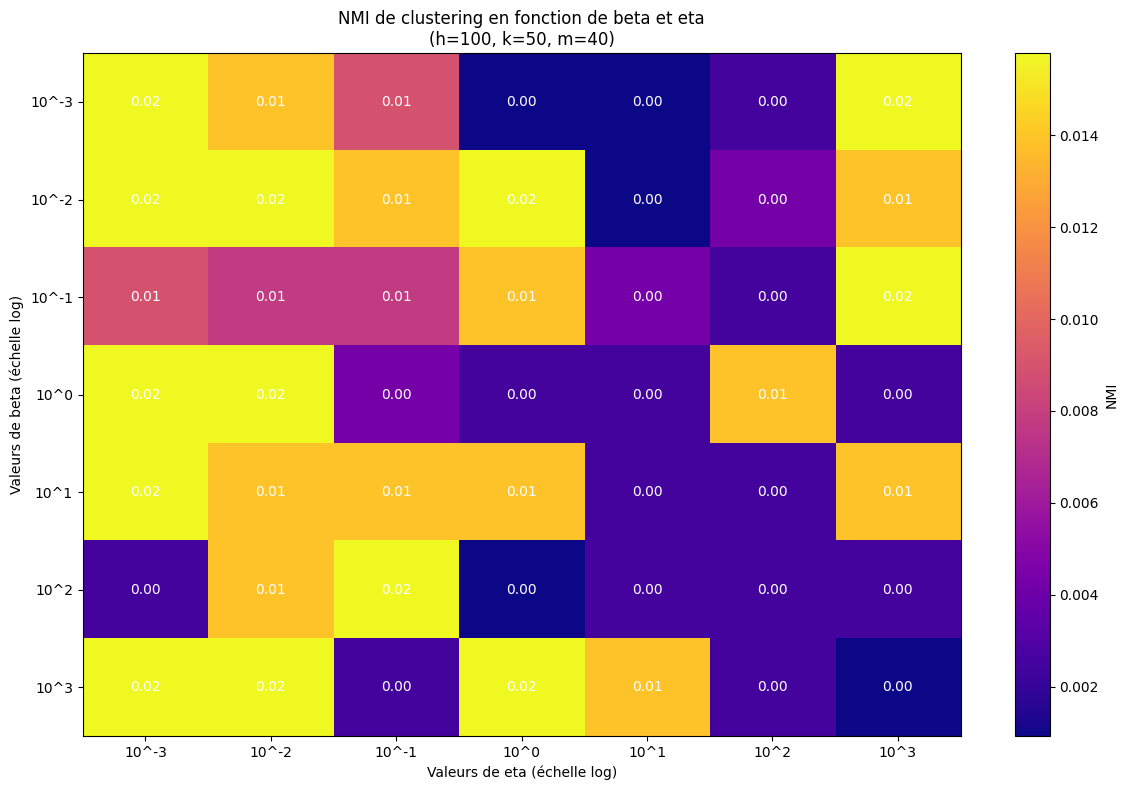

In [6]:
from scipy.io import loadmat
import numpy as np
from sklearn.cluster import KMeans
from collections import Counter
from math import log, sqrt
import matplotlib.pyplot as plt

# Fonction d'entropie
def entropy(labels):
    n = len(labels)
    label_counts = Counter(labels)
    return -sum((count/n) * log(count/n + 1e-10) for count in label_counts.values())

# Fonction d'information mutuelle
def mutual_info(y_true, y_pred):
    n = len(y_true)
    true_counts = Counter(y_true)
    pred_counts = Counter(y_pred)
    joint_counts = Counter(zip(y_true, y_pred))

    mi = 0.0
    for (yt, yp), count in joint_counts.items():
        p_joint = count / n
        p_yt = true_counts[yt] / n
        p_yp = pred_counts[yp] / n
        mi += p_joint * log(p_joint / (p_yt * p_yp) + 1e-10)
    return mi

# Fonction NMI manuelle
def nmi_manual(y_true, y_pred):
    mi = mutual_info(y_true, y_pred)
    h_true = entropy(y_true)
    h_pred = entropy(y_pred)
    return mi / sqrt(h_true * h_pred + 1e-10)

# Charger les données
mat_data = loadmat("C:\\Users\\PC\\Desktop\\PFE-MNSA\\DATA\\PCMAC.mat")
X = mat_data['X'].T
y_true = mat_data['Y'].flatten()

# Normalisation
X = (X - np.mean(X, axis=0)) / (np.std(X, axis=0) + 1e-10)

# Paramètres BGLR
k = 50
m = 40
h = 100
maxIter = 20

# Grilles de paramètres
beta_values = [10**i for i in range(-3, 4)]
eta_values = [10**i for i in range(-3, 4)]

# Matrice de résultats NMI
nmi_results = np.zeros((len(beta_values), len(eta_values)))

# Boucle principale
for i, beta in enumerate(beta_values):
    for j, eta in enumerate(eta_values):
        # Appel de BGLR (doit être défini par toi)
        W, index, newfea, lossFun = BGLR(X, k, m, h, beta, eta, maxIter)
        X_selected = newfea.T

        # Clustering
        n_clusters = len(np.unique(y_true))
        kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=0)
        y_pred = kmeans.fit_predict(X_selected)

        # Calcul NMI
        nmi = nmi_manual(y_true, y_pred)
        nmi_results[i, j] = nmi
        print(f"beta = {beta:.0e}, eta = {eta:.0e}, NMI = {nmi:.4f}")

# Heatmap
plt.figure(figsize=(12, 8))
plt.imshow(nmi_results, cmap='plasma', aspect='auto')

plt.xticks(np.arange(len(eta_values)), [f"10^{i}" for i in range(-3, 4)])
plt.yticks(np.arange(len(beta_values)), [f"10^{i}" for i in range(-3, 4)])
plt.xlabel('Valeurs de eta (échelle log)')
plt.ylabel('Valeurs de beta (échelle log)')
plt.title('NMI de clustering en fonction de beta et eta\n(h=100, k=50, m=40)')

# Barre de couleur
cbar = plt.colorbar()
cbar.set_label('NMI')

# Valeurs dans les cases
for i in range(len(beta_values)):
    for j in range(len(eta_values)):
        plt.text(j, i, f"{nmi_results[i, j]:.2f}", ha="center", va="center", color="w")

plt.tight_layout()
plt.show()
